## Import Libraries

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import sin, cos, atan2, sqrt, fabs, pi
from collections import defaultdict

## Compute Ocuupied Areas

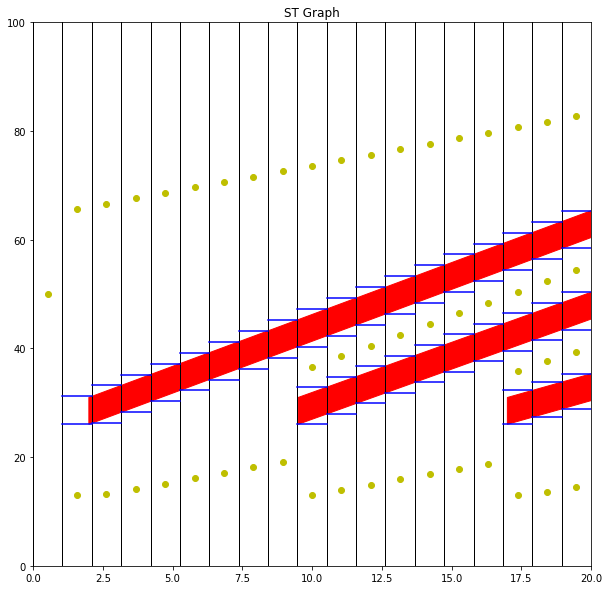

In [2]:
s_range = 100
t_range = 20
n_intervals = int(t_range)
length = 4.93

timeline = np.linspace(0, t_range, n_intervals)

# occupied_areas = [[2, 60, 8, 80], [5, 28, 20, 57]]

# Obstacle 1
# t & s
# 28.49822943032939 17.0
# 32.850470685656695 20
# Obstacle 2
# t & s
# 28.49822943032939 9.5
# 47.850470685656695 20
# 3
# 28.49822943032939 2.0
# 62.850470685656695 20
occupied_areas = [[17.0, 28.49822943032939, 20, 32.850470685656695],
                  [9.5, 28.49822943032939, 20, 47.850470685656695],
                  [2.0, 28.49822943032939, 20, 62.850470685656695]]

# occupied cells
occupied_cells = defaultdict(list)

candidate_cells = defaultdict(list)


""" degub plot """ 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_xlim(0, t_range)
ax.set_ylim(0, s_range)
plt.title('ST Graph')

for e in timeline:
    plt.axvline(e, ymax=1, color='k', linewidth=1) 

for area in occupied_areas:
    t_in, s_in = area[0], area[1]
    t_out, s_out = area[2], area[3]

    # Parallelogram
    x = [t_in, t_in, t_out, t_out]
    y = [s_in - length / 2, s_in + length / 2, 
         s_out + length / 2, s_out - length / 2]
    ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, color='r'))

# sort occupied areas with cut in time, then use sweep line method
for area in occupied_areas:
    t_in, s_in, t_out, s_out = area[0], area[1], area[2], area[3]
    
    # postion left boundary
    left = 0
    while timeline[left] < t_in:
        left += 1

    # postion right boundary
    right = len(timeline) - 1
    while timeline[right] > t_out:
        right -= 1
        
    if t_in < timeline[left]:
        if not occupied_cells[left-1]:
            occupied_cells[left-1] = []
        s1 = s_in
        s2 = np.interp(timeline[left], [t_in, t_out], [s_in, s_out])
        s_min = s1 - length / 2
        s_max = s2 + length / 2
        occupied_cells[left-1].append([s_min, s_max])
        ax.plot([timeline[left-1], timeline[left]], [s_min, s_min], 'b-')
        ax.plot([timeline[left-1], timeline[left]], [s_max, s_max], 'b-')
        
    for i in range(left, right):
        s1 = np.interp(timeline[i], [t_in, t_out], [s_in, s_out])
        s2 = np.interp(timeline[i+1], [t_in, t_out], [s_in, s_out])
        s_min = s1 - length / 2
        s_max = s2 + length / 2
        ax.plot([timeline[i], timeline[i+1]], [s_min, s_min], 'b-')
        ax.plot([timeline[i], timeline[i+1]], [s_max, s_max], 'b-')
        
        if not occupied_cells[i]:
            occupied_cells[i] = []
        occupied_cells[i].append([s_min, s_max])    

    if t_out > timeline[right]:
        if not occupied_cells[right]:
            occupied_cells[right] = []
        s1 = np.interp(timeline[right], [t_in, t_out], [s_in, s_out])
        s2 = s_out
        s_min = s1 - length / 2
        s_max = s2 + length / 2
        occupied_cells[right].append([s_min, s_max])
        ax.plot([timeline[right], timeline[right+1]], [s_min, s_min], 'b-')
        ax.plot([timeline[right], timeline[right+1]], [s_max, s_max], 'b-')
        
for i in range(len(timeline)-1):
    # print(timeline[i])
    entries = [0.0]
    boundaries = [0.0]
    if i in occupied_cells.keys():
        cells = occupied_cells[i]
        cells = sorted(cells, key = lambda x: x[0]) 
        for cell in cells:
            s_min = cell[0]
            s_max = cell[1]
            entries[-1] = ( entries[-1] + cell[0] ) / 2.0
            entries.append(cell[1])
            
            candidate_cells[i].append([boundaries[-1], cell[0]])
            
            boundaries.append(cell[0])
            boundaries.append(cell[1])
            
    entries[-1] = ( entries[-1] + 100.0 ) / 2.0
    candidate_cells[i].append([boundaries[-1], 100.0])
    
    ax.scatter([(timeline[i] + timeline[i+1])/2]*len(entries), entries, color='y')

plt.show()

In [3]:
print(len(occupied_cells))

18


## Counter-select unoccupied / viable areas

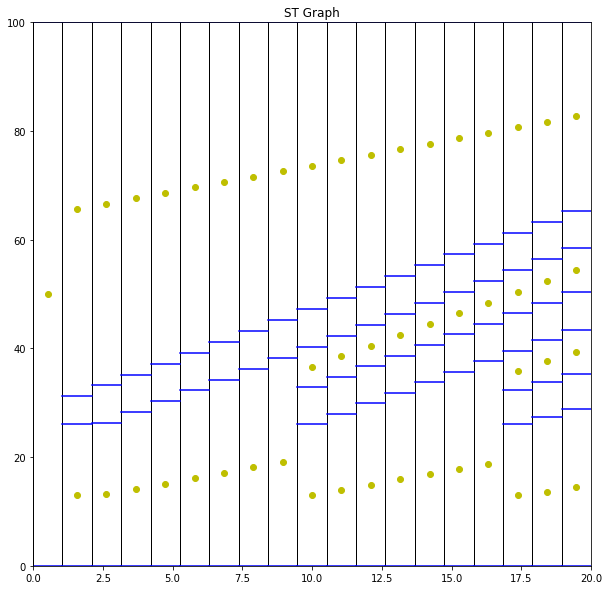

In [4]:
""" degub plot """ 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_xlim(0, t_range)
ax.set_ylim(0, s_range)
plt.title('ST Graph')

for e in timeline:
    plt.axvline(e, ymax=1, color='k', linewidth=1) 

for i in range(len(timeline)-1):
    cells = candidate_cells[i]
    cells = sorted(cells, key = lambda x: x[0]) 
    for cell in cells:
        s_min = cell[0]
        s_max = cell[1]
        ax.plot([timeline[i], timeline[i+1]], [s_min, s_min], 'b-')
        ax.plot([timeline[i], timeline[i+1]], [s_max, s_max], 'b-')
        ax.scatter([(timeline[i] + timeline[i+1])/2], (s_min + s_max)/2.0, color='y')
    
plt.show()

In [5]:
print(len(candidate_cells))
print(type(list(candidate_cells)))

19
<class 'list'>


## Search Vialbe Paths connecting the origin to the right side

BFS: Breadth First Search

In [6]:

def overlap(cell_a, cell_b):
    if cell_a[1] < cell_b[0] or cell_a[0] > cell_b[1]:
        return False
    return True

In [7]:
candidate_cells[0]

[[0.0, 100.0]]

In [8]:
# bfs
candidate_plans = []

candidate_plans.append(candidate_cells[0])

for i in range(1, len(timeline)-1):
    temp = []
    for plan in candidate_plans:
        prev_cell = plan[-1]
        for cell in candidate_cells[i]:
            if overlap(prev_cell, cell):
#                 plan.append(cell)
                temp.append(plan + [cell])
    candidate_plans = temp

print(len(candidate_plans))
 
    

4


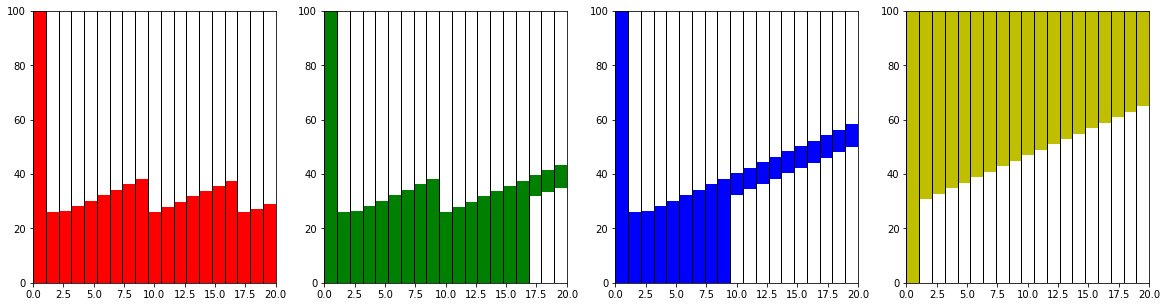

In [9]:
""" degub plot """ 
ax = [None] * len(candidate_plans)

fig = plt.figure(figsize=(5*len(candidate_plans),5))
for i in range(len(candidate_plans)):
    ax[i] = fig.add_subplot(('1' + str(len(candidate_plans)) + str(i+1)))

for i in range(len(candidate_plans)):
    ax[i].set_xlim(0, t_range)
    ax[i].set_ylim(0, s_range)

    for e in timeline:
        ax[i].axvline(e, ymax=1, color='k', linewidth=1) 

colors = ['r', 'g', 'b', 'y']
i = 0
for plan in candidate_plans:
    for t, cell in enumerate(plan):
        if t + 1 < len(timeline):
            # Parallelogram
            x = [timeline[t], timeline[t], timeline[t+1], timeline[t+1]]
            y = [cell[0], cell[1], cell[1], cell[0]]
            ax[i].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, color=colors[i]))
    i += 1
    print()
    
plt.show()

## Create example connected lines in each plan

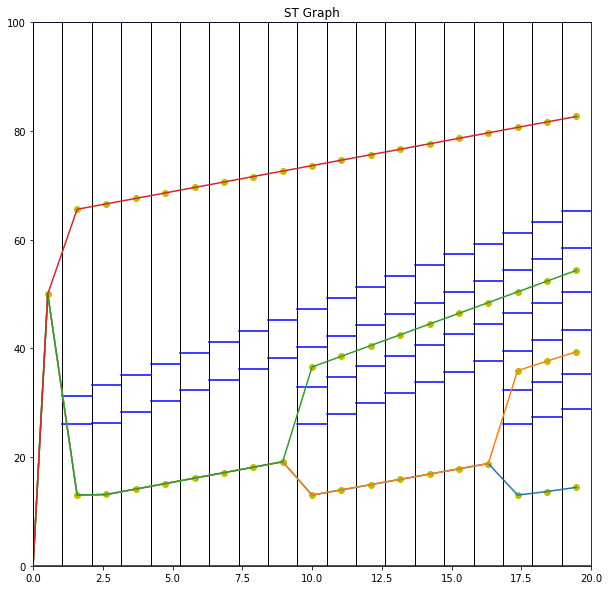

In [10]:
candidate_lines = []

for plan in candidate_plans:
    line_x = [0.0]
    line_y = [0.0]
    for i in range(len(timeline)-1):
        cell = plan[i]
        line_x.append( (timeline[i] + timeline[i+1])/2 )
        line_y.append( (cell[0]+cell[1]) / 2 )
    candidate_lines.append([line_x, line_y])
    
""" degub plot """ 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_xlim(0, t_range)
ax.set_ylim(0, s_range)
plt.title('ST Graph')

for e in timeline:
    plt.axvline(e, ymax=1, color='k', linewidth=1) 

for i in range(len(timeline)-1):
    cells = candidate_cells[i]
    cells = sorted(cells, key = lambda x: x[0]) 
    for cell in cells:
        s_min = cell[0]
        s_max = cell[1]
        ax.plot([timeline[i], timeline[i+1]], [s_min, s_min], 'b-')
        ax.plot([timeline[i], timeline[i+1]], [s_max, s_max], 'b-')
        ax.scatter([(timeline[i] + timeline[i+1])/2], (s_min + s_max)/2.0, color='y')

for line in candidate_lines:
    ax.plot(line[0], line[1])
        
plt.show()